In [2]:
!pip install tensorflow_text
# After running this cell, we have to restart the Kernel!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import tensorflow_text as text  # Registers the ops.

2024-08-18 08:38:49.407003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 08:38:49.407154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 08:38:49.542555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Import the Closed Questions on Stack Overflow Dataset

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample.csv")
df.shape

(140272, 15)

In [7]:
df.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
140267,2982729,06/06/2010 01:03:41,8303,09/15/2008 15:40:08,520,34,Is it possible to implement bitwise operators ...,I am facing a rather peculiar problem. I am wo...,bitwise-operators,discrete-mathematics,compiler-optimization,NaN,NaN,NaN,open
140268,8809105,01/10/2012 19:13:53,1130251,01/04/2012 15:31:10,1,0,Ruby on Rails: MySql Gem does not work: uninit...,I have the following installed:\r\nMac Os 10.7...,mysql,ruby-on-rails,gem,osx-lion,NaN,NaN,open
140269,10674791,05/20/2012 15:36:31,1388595,05/11/2012 04:43:47,4,0,deleting image from image folder,I am working with an asp.net application.I wan...,asp.net,NaN,NaN,NaN,NaN,05/21/2012 21:21:27,not a real question
140270,3997045,10/22/2010 13:04:30,484232,10/22/2010 13:04:30,1,0,Need help making HTML's,Hi to all the gurus out there.\r\n\r\nAnybody ...,html,copy,remove,move,NaN,10/22/2010 13:10:28,not a real question
140271,11570849,07/19/2012 23:36:57,1539253,07/19/2012 22:17:04,3,1,How dangerous is it to output certain content ...,Following on from a question I asked about esc...,php,content-management-system,NaN,NaN,NaN,NaN,open


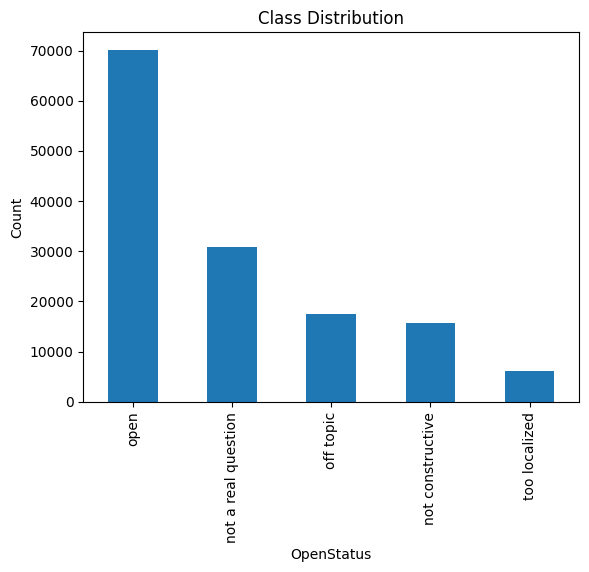

In [8]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the 'OpenStatus' column
df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [9]:
# Checking the number of samples from each class

class_distribution = df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: count, dtype: int64


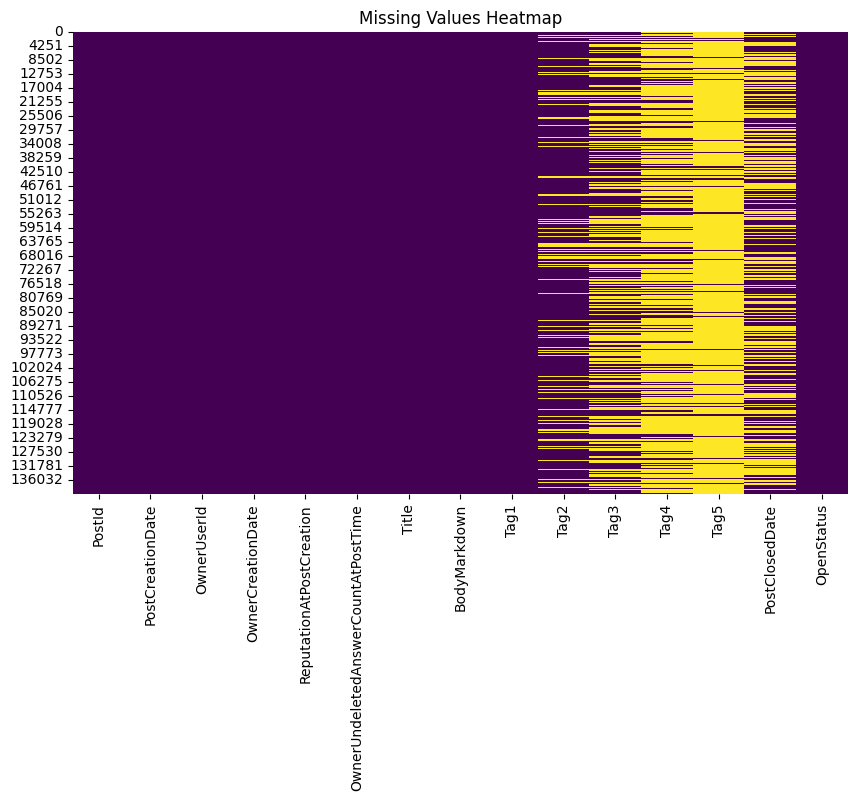

In [10]:
# Checking for missing values

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a boolean DataFrame indicating missing values
missing_values = df.isnull()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### 3. Preparing Input Data for Training and Evaluation

In [11]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into train, validation and test (70%, 20% and 10% respectively)
train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.OpenStatus.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.50, stratify=remaining.OpenStatus.values)



# Display the shapes of the downsampled training and validation datasets
train_df.shape, valid_df.shape, test_df.shape

((112217, 15), (14027, 15), (14028, 15))

In [12]:
# Checking the number of samples from each class of train_df

class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
open                   56109
not a real question    24631
off topic              14024
not constructive       12527
too localized           4926
Name: count, dtype: int64


The given dataset has a tremendous data imbalance for different classes. One possible approach can be to downsample all of 'open', 'not a real question', 'off topic' and 'not constructive' classes to the size of the 'too localized' class.

In [13]:
from sklearn.utils import resample

# Separating different classes in the dataset
open_class = train_df[train_df.OpenStatus == 'open']
not_a_real_question_class = train_df[train_df.OpenStatus == 'not a real question']
off_topic_class = train_df[train_df.OpenStatus == 'off topic']
not_constructive_class = train_df[train_df.OpenStatus == 'not constructive']
too_localized_class = train_df[train_df.OpenStatus == 'too localized']


# Downsampling the 5 classes to the size of the 'off topic' class
open_class = resample(open_class,
                      replace=False,  # sample without replacement
                      n_samples=len(too_localized_class),  # match target class size
                      random_state=42)  # for reproducible results

not_a_real_question_class = resample(not_a_real_question_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

off_topic_class = resample(off_topic_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

not_constructive_class = resample(not_constructive_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

# Combining all the minority class with the resampled classes
train_df = pd.concat([open_class, 
                not_a_real_question_class, 
                off_topic_class, 
                not_constructive_class, 
                too_localized_class])

# Shuffle the downsampled training dataset
train_df = train_df.sample(frac=1, random_state=42)

In [14]:
train_df.shape

(24630, 15)

In [15]:
# Checking the number of samples from each class of train_df

class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
too localized          4926
off topic              4926
not a real question    4926
not constructive       4926
open                   4926
Name: count, dtype: int64


In [16]:
train_df.tail(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
136603,8308545,11/29/2011 09:37:53,834663,07/08/2011 03:12:08,1,0,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,mybatis,struts1,NaN,NaN,NaN,04/20/2012 15:26:06,too localized
14150,3717059,09/15/2010 11:16:09,445646,09/12/2010 16:05:54,6,0,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,php,frameworks,content-management-system,NaN,NaN,09/15/2010 11:52:29,not a real question
109104,7207041,08/26/2011 15:25:15,835038,07/08/2011 08:54:05,143,2,Looking for Locations API (c#),In my app i am allowing users to enter there c...,c#,NaN,NaN,NaN,NaN,NaN,open
135635,6737574,07/18/2011 18:31:12,301736,03/25/2010 13:53:40,49,0,Simple Silverlight Examples,I have just started learning silverlight. When...,silverlight-4.0,NaN,NaN,NaN,NaN,05/23/2012 08:54:38,not constructive
73465,11249188,06/28/2012 16:39:44,499017,11/06/2010 03:46:32,1,0,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,php,joomla2.5,stdclass,NaN,NaN,07/02/2012 03:16:24,too localized


I have decided to use only the "Title", "BodyMarkdown" and "OpenStatus" columns from the dataframe. The "Title" and  "BodyMarkdown" can be joined together to create the text input and the "OpenStatus" column is our target column.

In [17]:
selected_columns = ['Title', 'BodyMarkdown', 'OpenStatus', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
train_df = train_df[selected_columns]
valid_df = valid_df[selected_columns]
test_df = test_df[selected_columns]

In [18]:
train_df.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5
136603,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,too localized,mybatis,struts1,NaN,NaN,NaN
14150,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,not a real question,php,frameworks,content-management-system,NaN,NaN
109104,Looking for Locations API (c#),In my app i am allowing users to enter there c...,open,c#,NaN,NaN,NaN,NaN
135635,Simple Silverlight Examples,I have just started learning silverlight. When...,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN
73465,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,too localized,php,joomla2.5,stdclass,NaN,NaN


Here, I have combined the "Title", "Tag1 to Tag5" and "BodyMarkdown" columns to create a single text input.

In [19]:
for index, row in train_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}"
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    train_df.at[index, 'text'] = text
    

for index, row in valid_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}" 
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    valid_df.at[index, 'text'] = text

for index, row in test_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    #text += " Tags: {" + ', '.join(str(tag) for tag in [row.Tag1, row.Tag2, row.Tag3, row.Tag4, row.Tag5] if not pd.isnull(tag)) + "}"
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    test_df.at[index, 'text'] = text

In [20]:
train_df.tail(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
136603,cant find org/apache/ibatis/io/Resources,I use **mybatis** and **struts1** I want to ad...,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...
14150,PHP-Framework or CMS .. ?,I want to know that which framework/CMS is the...,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...
109104,Looking for Locations API (c#),In my app i am allowing users to enter there c...,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...
135635,Simple Silverlight Examples,I have just started learning silverlight. When...,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...
73465,Call to undefined method stdClass::onDisplay()...,I have a joomla 2.5 installation. I just insta...,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...


Now, I have dropped the "Title" and "BodyMarkdown" columns from the dataframe.

In [21]:
columns_to_drop = ['Title', 'BodyMarkdown']
train_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [22]:
train_df.shape

(24630, 7)

In [23]:
train_df.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
136603,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...
14150,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...
109104,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...
135635,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...
73465,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...


In [24]:
for index, row in train_df.iterrows():
    print("Text: ")
    print("________________________")
    print(row.text, end='\n\n\n\n')
    print("Target Class:")
    print("________________________")
    print(row.OpenStatus)
    break

Text: 
________________________
Title: 'My application works on all browsers, but in IE doesn't work, it works in debug mode in IE only,'  Body: 'this is the application I developed: games.ourcity-sy.com

in IE(I tried 9 and 8)  and  it doesn't work well in the normal mode, but when I get to debug mode F12, it works with some problems,

what could be the solution??'



Target Class:
________________________
too localized


Now we have to encode the Target column into numerical values.

In [25]:
# Definelabel mapping
custom_label_mapping = {'open': 0, 
                        'not a real question': 1, 
                        'off topic': 2,
                        'not constructive': 3, 
                        'too localized': 4
                       }  

# Initialize LabelEncoder with custom mapping
encoded_labels = []
for index, row in train_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
train_df['OpenStatus_encoded'] = encoded_labels



# Applying the same changes to valid_df and test_df

encoded_labels = []
for index, row in valid_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
valid_df['OpenStatus_encoded'] = encoded_labels



encoded_labels = []
for index, row in test_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
test_df['OpenStatus_encoded'] = encoded_labels

In [26]:
train_df.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text,OpenStatus_encoded
136603,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...,4
14150,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...,1
109104,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...,0
135635,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...,3
73465,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...,4


In [27]:
train_df.shape

(24630, 8)

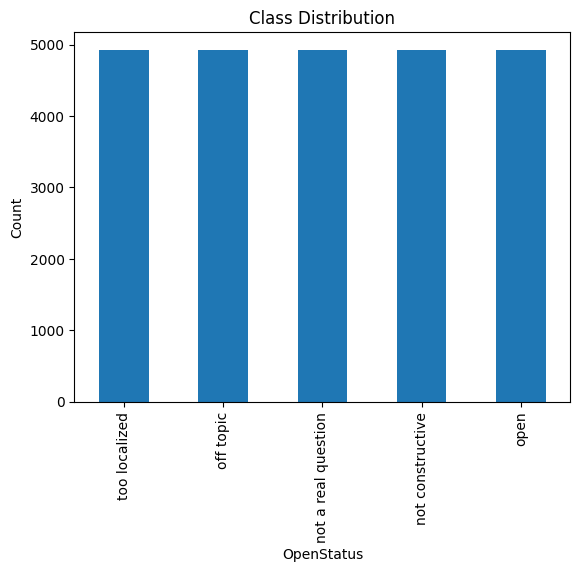

In [28]:
# Assuming df is your DataFrame containing the 'OpenStatus' column
train_df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [29]:
X_train = train_df["text"]
y_train = train_df["OpenStatus_encoded"]

X_valid = valid_df["text"]
y_valid = valid_df["OpenStatus_encoded"]

X_test = test_df["text"]
y_test = test_df["OpenStatus_encoded"]

In [30]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(24630,)
(24630,)
(14027,)
(14027,)
(14028,)
(14028,)


### 4. Input Format for BERT

**Token IDs** - This corresponds to the tokenized strings padded with 0s
                upto the max sequence length and beginning with CLS and ending with SEP. <br><br>
**Input Mask** - Note that BERT uses Self-Attention Networks to provide
                 contextualised embeddings corresponding to each token in the token string i.e., for each word in the string BERT looks to the left and right of it in the sentence so as to find contextual meaning of the word in the sentence (say, if there is a "the", then look at the noun to which it points). Now, note that we have padded our token strings with 0s upto the max seq length, but we do not want the padding 0s to influence the contextual information to be derived.  The Input Mask is a list of same length as the length of Token Ids (ie the max seq length) where there is a 0 for a padding and 1 for a valid token. The 0s will cancel out the internal multiplications that we perform for capturing the Self Attention for contextual information. <br><br>

**Input Type IDs** - Note that originally BERT was pretrained on two   tasks, Masked Language Modelling (where random words from the sentence would be masked and it would be the task for the BERT to predict what those masked words are) and the other task was Next Sentence Prediction or NSP (Given two sentences, the BERT has to predict which came first and which came after. The first sentence was given the value 0 and the next sentence was given the value 1).<br><br>
**In Text classification, we are dealing with only 1 sequence at a time, so our input type IDs would just be a vector with all values 0. **


### 5. Checking the tokenization process

In [31]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

Upon checking the input word ids, we find that the tokens are --> "Hello", "#,", "how", "are", "you" and "#?" {'#' signifies that the succeeding character ',' is attached to characters before] and they are encoded as [7592 1010 2129 2024 2017 1029]. 

Note that this is not the whole story. We also have to make sure that each sequence is initiated with the CLS token (which signifies start of sequence and has a token_id 101) and ended with SEP (separator) which means end of sequence and has a token_id 102. Also we have to make sure that all tensors have sequence size equal to the max_sequence_length by using padding.

### 6. Add a Classification Head to the BERT Layer

We only need the pooled_output that represents the whole sentence (using the CLS token that contains the contextual information of the whole sentence) and not the sequence_output.

In [32]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].





# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.5)(pooled_output)
batch_norm1 = tf.keras.layers.BatchNormalization()(drop1)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(512, activation='relu')(batch_norm1)
drop2 = tf.keras.layers.Dropout(0.4)(hidden1)
batch_norm2 = tf.keras.layers.BatchNormalization()(drop2)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm2)
drop3 = tf.keras.layers.Dropout(0.3)(hidden2)
batch_norm3 = tf.keras.layers.BatchNormalization()(drop3)
hidden3 = tf.keras.layers.Dense(32, activation='relu')(batch_norm3)
drop4 = tf.keras.layers.Dropout(0.2)(hidden3)
batch_norm4 = tf.keras.layers.BatchNormalization()(drop4)

# Output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output')(batch_norm4)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


### 7. Fine-Tune BERT for Text Classification

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [34]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-10  # Lower bound on the learning rate
    )
]

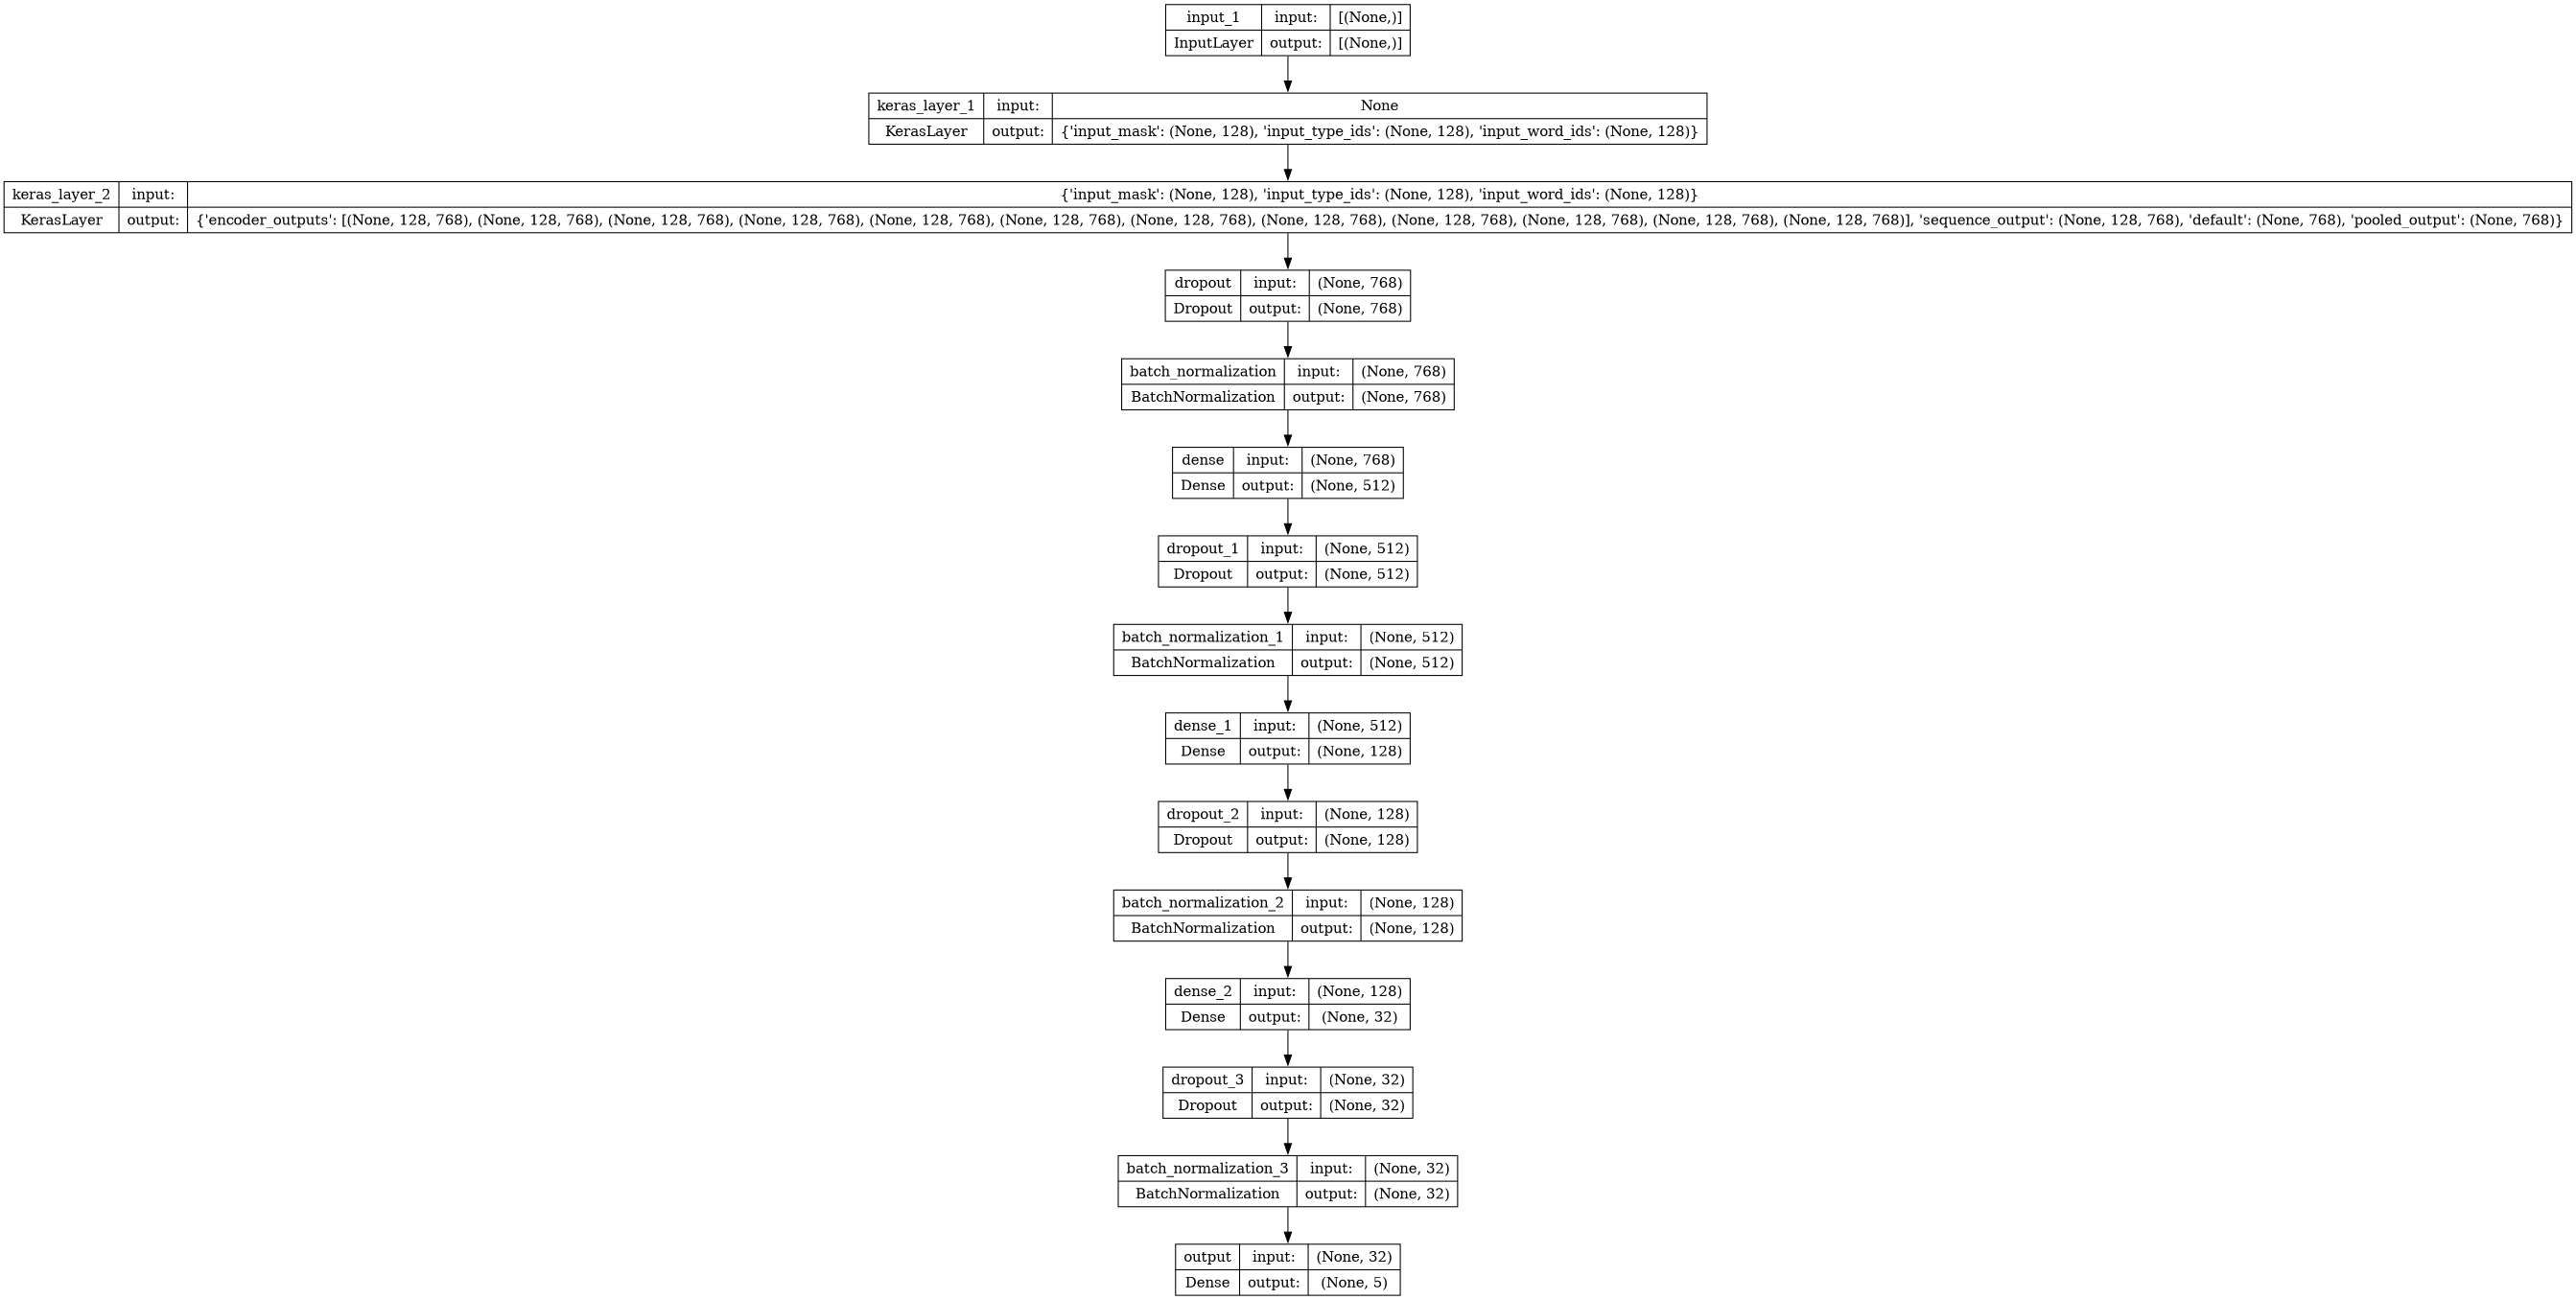

In [35]:
# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [36]:
# Train model
epochs = 10
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1723970420.173671      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


770/770 [==============================] - ETA: 0s - loss: 1.9761 - accuracy: 0.2730
Epoch 1: val_accuracy improved from -inf to 0.26249, saving model to best_model.h5
770/770 [==============================] - 556s 662ms/step - loss: 1.9761 - accuracy: 0.2730 - val_loss: 1.5776 - val_accuracy: 0.2625 - lr: 2.0000e-05
Epoch 2/10
770/770 [==============================] - ETA: 0s - loss: 1.6740 - accuracy: 0.3752
Epoch 2: val_accuracy improved from 0.26249 to 0.33671, saving model to best_model.h5
770/770 [==============================] - 508s 660ms/step - loss: 1.6740 - accuracy: 0.3752 - val_loss: 1.5099 - val_accuracy: 0.3367 - lr: 2.0000e-05
Epoch 3/10
770/770 [==============================] - ETA: 0s - loss: 1.4965 - accuracy: 0.4413
Epoch 3: val_accuracy improved from 0.33671 to 0.43181, saving model to best_model.h5
770/770 [==============================] - 506s 658ms/step - loss: 1.4965 - accuracy: 0.4413 - val_loss: 1.3554 - val_accuracy: 0.4318 - lr: 2.0000e-05
Epoch 4/10
7

### 8. Check the loss and accuracy curves

In [37]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

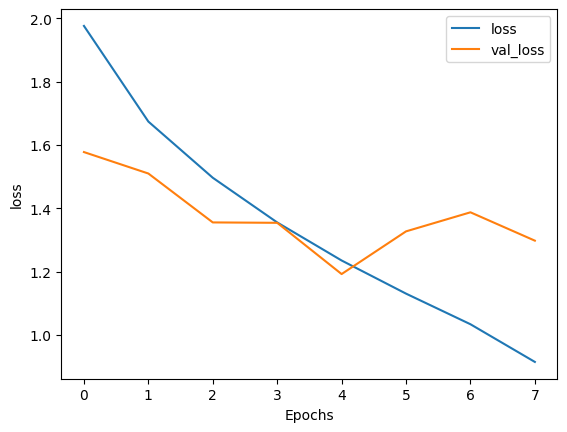

In [51]:
plot_graphs(history, 'loss')

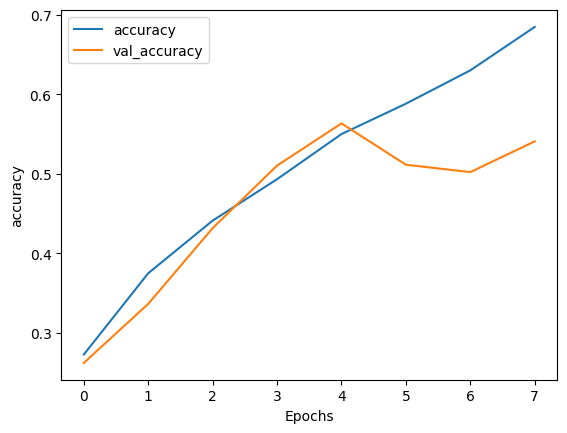

In [52]:
plot_graphs(history, 'accuracy')

## 9. Evaluating on Test Dataframe

In [53]:
from sklearn.metrics import accuracy_score, log_loss


# Obtain predictions from the BERT model
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", round(accuracy * 100, 4) , "%")

# Compute sparse categorical cross-entropy loss
loss = log_loss(y_test, predictions)
print("Sparse Categorical Cross-Entropy Loss:", loss)

439/439 [==============================] - 94s 214ms/step
Accuracy: 57.2284 %
Sparse Categorical Cross-Entropy Loss: 1.1768457763094637


#### Confusion Matrix

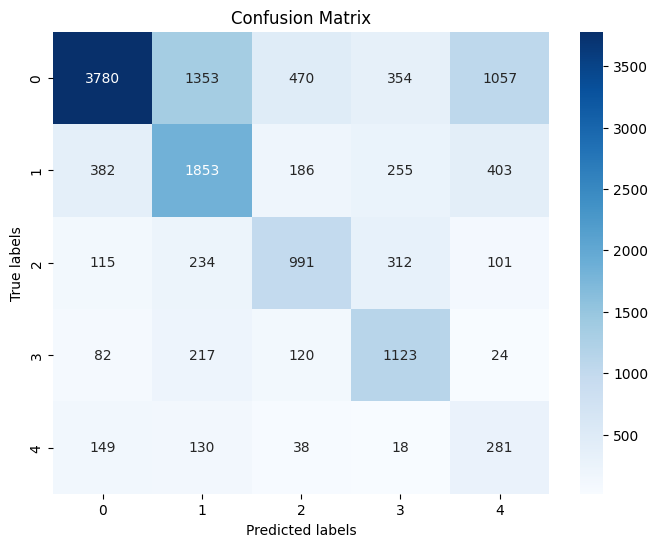

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(5)], 
            yticklabels=[str(i) for i in range(5)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 10. Sanity Checks

In [42]:
import random
import matplotlib.pyplot as plt

In [43]:
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

In [44]:
print(len(X_test_list))
print(len(y_test_list))

14028
14028


custom_label_mapping = <br>{<br>'open': 0, <br>
                        'not a real question': 1, <br>
                        'off topic': 2, <br>
                        'not constructive': 3, <br>
                        'too localized': 4 <br>
                       }  

In [45]:
label_to_class_map = {0 : 'open',
                      1 : 'not a real question',
                      2 : 'off topic',
                      3 : 'not constructive',
                      4 : 'too localized'}

#### Check 1

___________________________________________________


TEXT:


Title: 'See SQL From EntityFramework with Collection-like Queries'  Body: 'I do not have 'full' the version of MS SQL (SQL Express 2008) so I do not have the profiler tool. 

I want to see the SQL generated by my Entity Framework code, but all of the examples I find use the 

    var x = from u in table
            select u;

type of syntax; But most of my queries are more like ..

    var x = context.Users.Single(n => n.Name == "Steven");

type of syntax. What can I do to see the SQL generated, from this manner of coding? Any ideas?
'



___________________________________________________


GROUND TRUTH:


open



___________________________________________________



1/1 [==============================] - 1s 1s/step


PREDICTION:




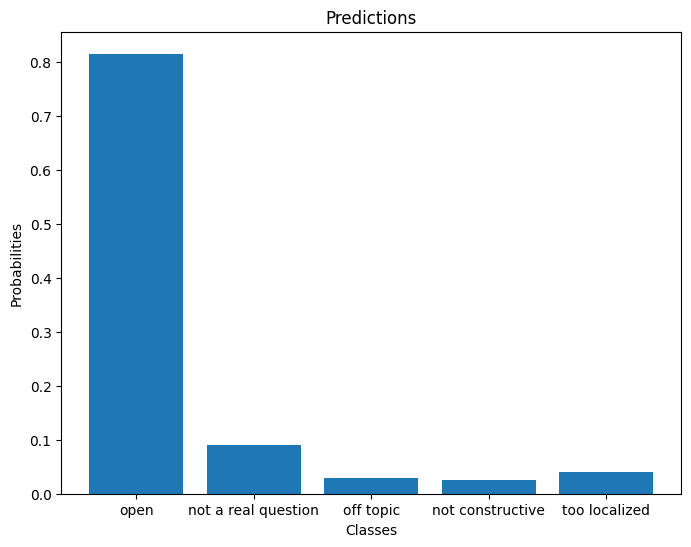




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [46]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 2

___________________________________________________


TEXT:


Title: 'Change date on android'  Body: 'I dropped my phone,the battery fell out. Put it back in turned on phone and my time was wrong and the date was jan. 5 1980. How do I change to current time and date?
'



___________________________________________________


GROUND TRUTH:


off topic



___________________________________________________



1/1 [==============================] - 0s 43ms/step


PREDICTION:




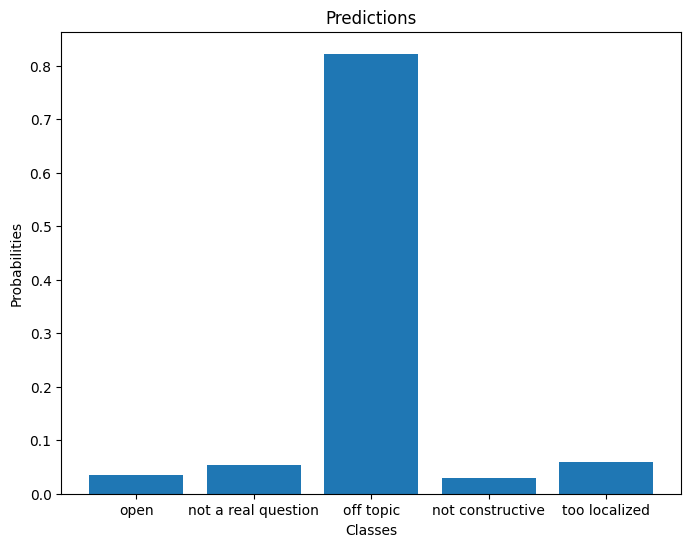




___________________________________________________


PREDICTED CLASS:  off topic



___________________________________________________



CORRECT PREDICTION !!!


In [47]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 3

___________________________________________________


TEXT:


Title: 'Jquery turning a negative (-) into a normal number'  Body: 'So i have two vairbales which when one is devided by the other will give me a negative number

-1
-2
-3

and so on

what i need is to get this lets say -2 into a vairable which is 2 not -2

how can one achive this

this is my code to come up with the - value:

    var slideNumberOn = (left_indent / divWidth);

i found something like the below but it does not work:
        
    var slideNumberOn = (left_indent / divWidth);
    var slideNumberOnNoMinus = slideNumberOn.replace('-',"");'



___________________________________________________


GROUND TRUTH:


not a real question



___________________________________________________



1/1 [==============================] - 0s 46ms/step


PREDICTION:




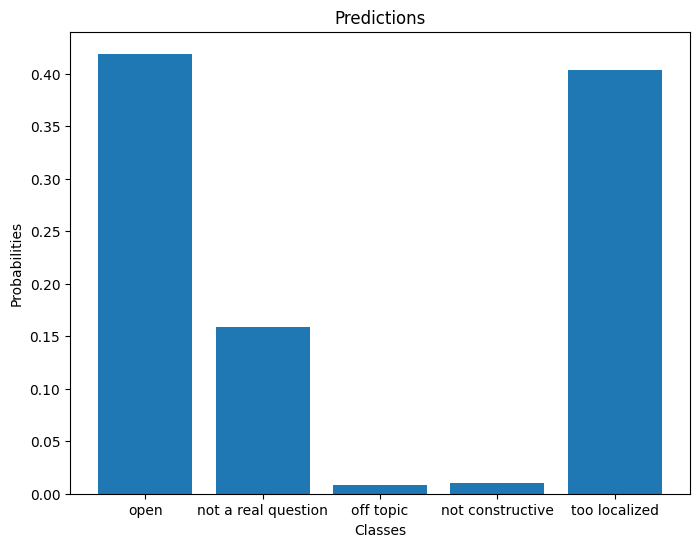




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



WRONG PREDICTION !!!


In [48]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 4

___________________________________________________


TEXT:


Title: 'htaccess url rewrite to .php'  Body: 'I have the below url

    http://www.***.org/aaddress.php?state=nm&office_id=852&office_name=CLOVIS&state_name=New%20Mexico

I want to change it the below url

    http://www.*****.org/aaddress-state-nm-office_id-852-office_name-CLOVIS-state_New%20Mexico.php

I have used below htaccess code

    Options +FollowSymLinks
    RewriteEngine on
    
    RewriteRule aaddress-state-(.*)-office_id-(.*)-office_name-(.*)-state_name-(.*)\.php aaddress.php?state=$1&office_id=$2&office_name=$3&state_name=$4

It's not working, when i click write the address didn't convert to the .php page

My links inside the pages as the 1st link and want to change it as the .php link

'



___________________________________________________


GROUND TRUTH:


off topic



___________________________________________________



1/1 [==============================] - 0s 48ms/step


PREDICTION:




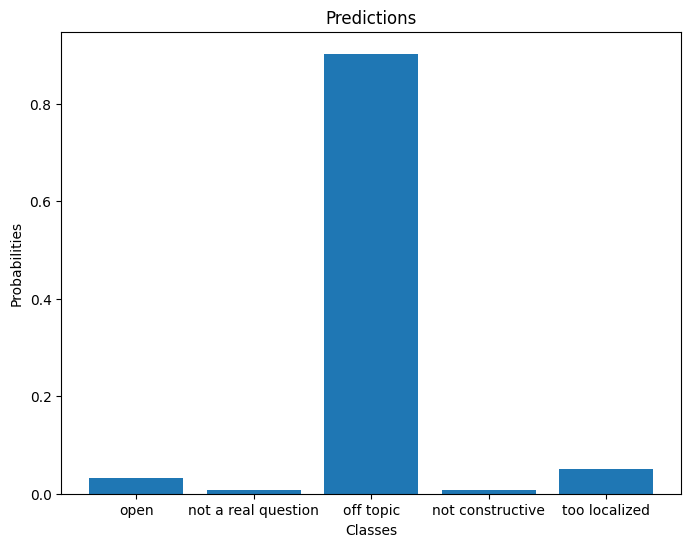




___________________________________________________


PREDICTED CLASS:  off topic



___________________________________________________



CORRECT PREDICTION !!!


In [49]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")

#### Check 5

___________________________________________________


TEXT:


Title: 'Control order of updates in hibernate'  Body: 'I have a table with a unique column, "token", enforced by a unique constraint in the database. In a certain case, I need to change an existing row to have the same token as another existing row, changing the 2nd row to have a new value.

So, say I have:

id;token
0;'aaa'
1;'bbb'

I want id 0 ('aaa') to instead have the token 'bbb'. So I need to change 'bbb' to be 'jfeisefjse', and then I can change 'aaa' to be 'bbb'. This can be done in postgres in a single tranasction.

I've tried to do the same thing in code: In one transaction I get the token from the existing row (row 1), I set it to be a random value, I update the other row (row 0) to have row 1's token, then I commit. However hibernate doesn't respect the order I've done the commits in. It seems to always run the update statement for row 0 first, and postgres complains that it's violating a foreign key constraint.


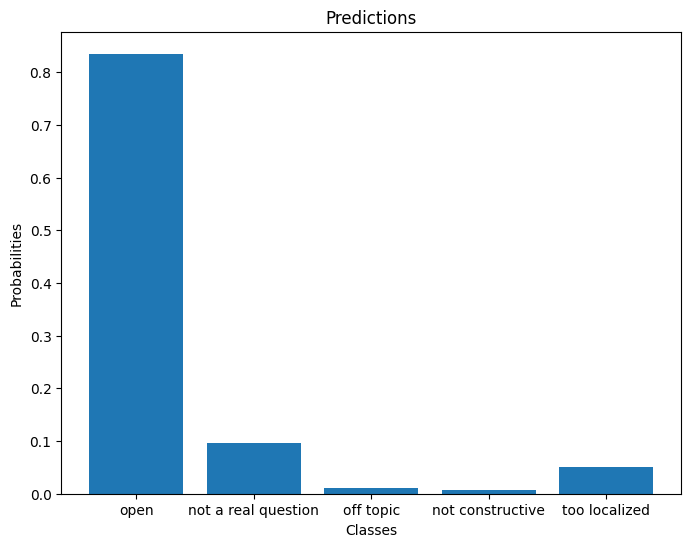




___________________________________________________


PREDICTED CLASS:  open



___________________________________________________



CORRECT PREDICTION !!!


In [50]:
# Generate a random integer between 1 and 100 (inclusive)
rand_int = random.randint(0, 14028)

print("___________________________________________________")
print("\n\nTEXT:\n\n")
print(X_test_list[rand_int])
print("\n\n")
print("___________________________________________________")
print("\n\nGROUND TRUTH:\n\n")
print(label_to_class_map[y_test_list[rand_int]])
print("\n\n")
print("___________________________________________________")


print("\n\n")
prediction = model.predict([X_test_list[rand_int]])
print("\n\nPREDICTION:\n\n")

categories = ['open', 
              'not a real question', 
              'off topic',
              'not constructive',
              'too localized'
             ]

plt.figure(figsize=(8, 6))
plt.bar(categories, prediction[0])
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions')
plt.show()
print("\n\n")
print("___________________________________________________")





predicted_class_index = np.argmax(prediction)
print("\n\nPREDICTED CLASS: ", label_to_class_map[predicted_class_index])
print('\n\n')
print("___________________________________________________")



print("\n\n")
if label_to_class_map[predicted_class_index] == label_to_class_map[y_test_list[rand_int]]:
    print("CORRECT PREDICTION !!!")
else:
    print("WRONG PREDICTION !!!")